In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from utils import load_series_dfs

In [2]:
series_dfs = load_series_dfs(data_dir=r"C:\Users\johan\Documents\FH_Master\data", filename="final_learning_dfs.pkl")
series_dfs['FL_00024702.PLAN.MengeHH'].columns

Index(['consumption', 'hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
       'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10',
       'w_tb20', 'CEGH_WAP', 'THE_WAP'],
      dtype='object')

In [4]:
series_dfs.keys()

dict_keys(['FL_00024702.PLAN.MengeHH', 'FL_00024730.PLAN.MengeHH', 'FL_00352243.PLAN.MengeHH', 'FL_00352244.PLAN.MengeGA', 'FL_00352244.PLAN.MengeKW', 'FL_00024360.PLAN.MengeGA', 'FL_00352254.PLAN.MengeGA', 'FL_00025248.PLAN.MengeGA', 'FL_00024360.PLAN.MengeHH.2', 'FL_00024731.PLAN.MengeHH', 'FL_00024735.PLAN.MengeHH', 'FL_00024667.PLAN.MengeHH', 'FL_00352218.PLAN.MengeHH', 'FL_00025240.PLAN.MengeHH', 'FL_00025241.PLAN.MengeHH', 'FL_00020896.PLAN.MengeHH', 'FL_00342704.PLAN.MengeGA', 'FL_00352054.PLAN.MengeHH', 'CV_00348266.PLAN.Menge', 'FL_00352254.PLAN.MengeHH', 'FL_00352244.PLAN.MengeHH', 'FL_00342704.PLAN.MengeHH', 'CV_00003083.PLAN.Menge', 'CV_00003181.PLAN.Menge', 'CV_00003192.PLAN.Menge', 'CV_00003191.PLAN.Menge', 'CV_00003183.PLAN.Menge', 'CV_00001876.PLAN.Menge', 'CV_00003094.PLAN.Menge', 'CV_00003089.PLAN.Menge', 'CV_00007270.PLAN.Menge', 'CV_00007300.PLAN.Menge', 'KN_00001613.PLAN.Menge', 'KN_00000069.PLAN.Menge', 'KN_00000067.PLAN.Menge', 'CV_00007809.PLAN.Menge', 'FL_00352

In [5]:
type(series_dfs)

dict

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Hilfsfunktion: Profil berechnen ---
def build_profile(df, mode="24h"):
    """
    mode = "24h": mittleres Stundenprofil (0-23)
    mode = "168h": mittleres Wochenprofil (0-167)
    """
    if mode == "24h":
        profile = df.groupby("hour")["consumption"].mean()
        return profile.values  # Vektor mit 24 Elementen

    elif mode == "168h":
        # Wochentag*24 + Stunde -> 0..167
        df = df.copy()
        df["week_hour"] = df["weekday"] * 24 + df["hour"]
        profile = df.groupby("week_hour")["consumption"].mean()
        return profile.values  # Vektor mit 168 Elementen

# --- 1) Profile für alle Serien berechnen ---
profiles_24h = {}
profiles_168h = {}

for key, df in series_dfs.items():
    # Index vorbereiten (so wie du es beschrieben hast)
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.duplicated(keep='first')]
    df = df.sort_index().resample('h').interpolate().asfreq('h')

    # Profile
    profiles_24h[key] = build_profile(df, "24h")
    profiles_168h[key] = build_profile(df, "168h")

# --- 2) In Matrizen umwandeln ---
X_24h = np.vstack(list(profiles_24h.values()))
X_168h = np.vstack(list(profiles_168h.values()))

# Skalieren (wichtig, sonst dominieren große Serien)
X_24h = StandardScaler().fit_transform(X_24h)
X_168h = StandardScaler().fit_transform(X_168h)

# --- 3) Clustering + Silhouette Scores ---
def evaluate_clustering(X, name, k_range=range(2,8)):
    scores = {}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(X)
        score = silhouette_score(X, labels)
        scores[k] = score
    print(f"{name} Profile - Silhouette Scores:", scores)
    return scores

scores_24h = evaluate_clustering(X_24h, "24h")
scores_168h = evaluate_clustering(X_168h, "168h")

# --- 4) Vergleichen ---
best_24h = max(scores_24h, key=scores_24h.get)
best_168h = max(scores_168h, key=scores_168h.get)

print("Beste Clusterzahl 24h:", best_24h, "Score:", scores_24h[best_24h])
print("Beste Clusterzahl 168h:", best_168h, "Score:", scores_168h[best_168h])


24h Profile - Silhouette Scores: {2: np.float64(0.979738273767288), 3: np.float64(0.9055309905875388), 4: np.float64(0.7953609894226265), 5: np.float64(0.6005355745737615), 6: np.float64(0.6041176257077168), 7: np.float64(0.5468070692344285)}
168h Profile - Silhouette Scores: {2: np.float64(0.9608673966845277), 3: np.float64(0.9065085626969929), 4: np.float64(0.7548993252424029), 5: np.float64(0.6009864121699332), 6: np.float64(0.6037649405269008), 7: np.float64(0.6147837930253084)}
Beste Clusterzahl 24h: 2 Score: 0.979738273767288
Beste Clusterzahl 168h: 2 Score: 0.9608673966845277


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\sit

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


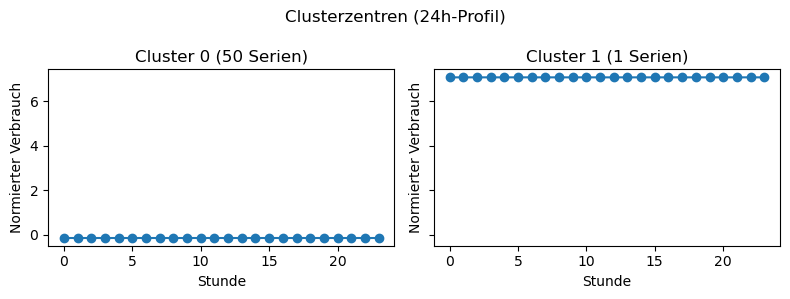

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


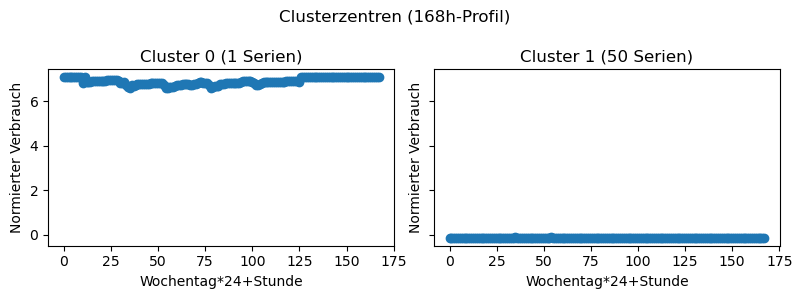

In [7]:
import matplotlib.pyplot as plt

def plot_cluster_centers(X, labels, mode="24h"):
    """
    X: Profil-Matrix (n_series x n_features)
    labels: Cluster-Zuordnung jeder Serie
    mode: "24h" oder "168h"
    """
    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 3), sharey=True)

    if n_clusters == 1:
        axes = [axes]  # falls nur 1 Cluster

    for i, ax in enumerate(axes):
        cluster_profiles = X[labels == i]
        center = cluster_profiles.mean(axis=0)  # Durchschnittsprofil
        ax.plot(center, marker="o")
        ax.set_title(f"Cluster {i} ({len(cluster_profiles)} Serien)")
        ax.set_xlabel("Stunde" if mode=="24h" else "Wochentag*24+Stunde")
        ax.set_ylabel("Normierter Verbrauch")

    plt.suptitle(f"Clusterzentren ({mode}-Profil)")
    plt.tight_layout()
    plt.show()

# --- Beispiel: mit bestem k aus 24h-Profilen ---
best_k_24h = max(scores_24h, key=scores_24h.get)
km_24h = KMeans(n_clusters=best_k_24h, random_state=42, n_init="auto").fit(X_24h)
labels_24h = km_24h.labels_

plot_cluster_centers(X_24h, labels_24h, mode="24h")

# --- Beispiel: mit bestem k aus 168h-Profilen ---
best_k_168h = max(scores_168h, key=scores_168h.get)
km_168h = KMeans(n_clusters=best_k_168h, random_state=42, n_init="auto").fit(X_168h)
labels_168h = km_168h.labels_

plot_cluster_centers(X_168h, labels_168h, mode="168h")

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


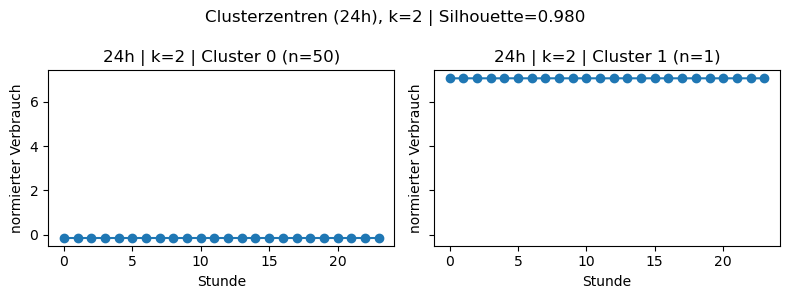

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


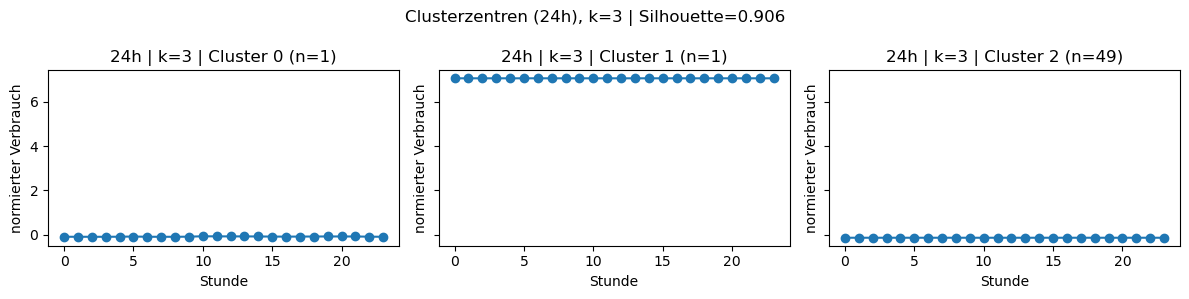

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


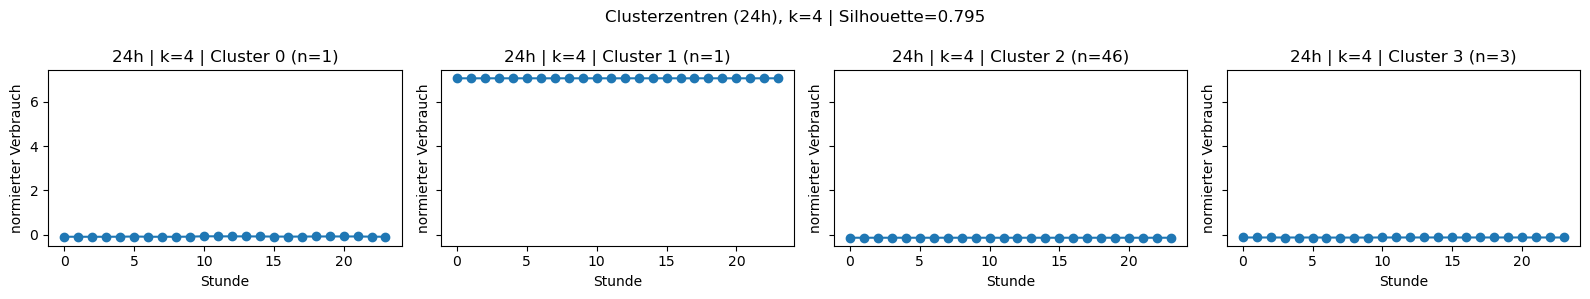

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


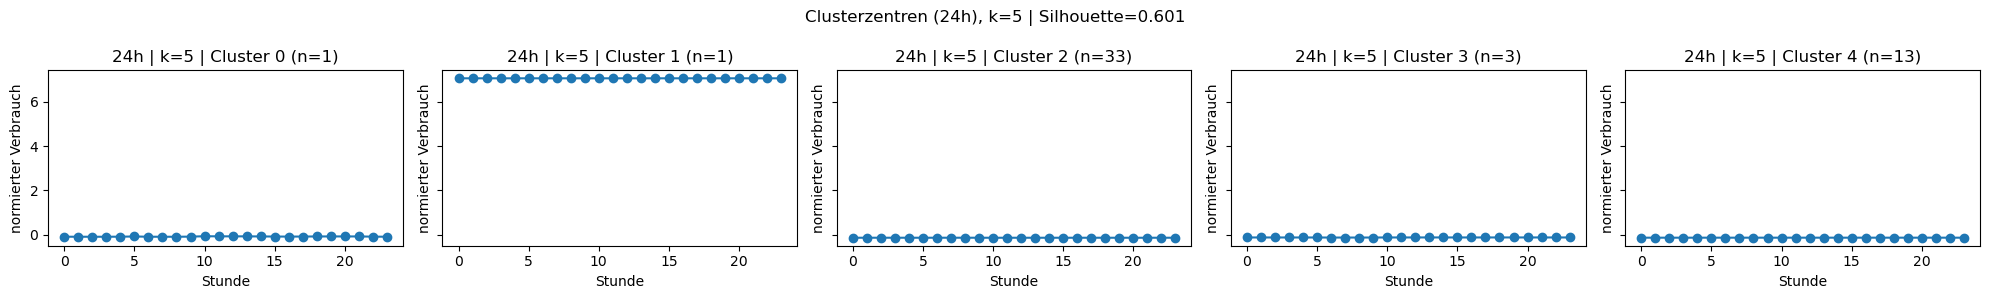

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


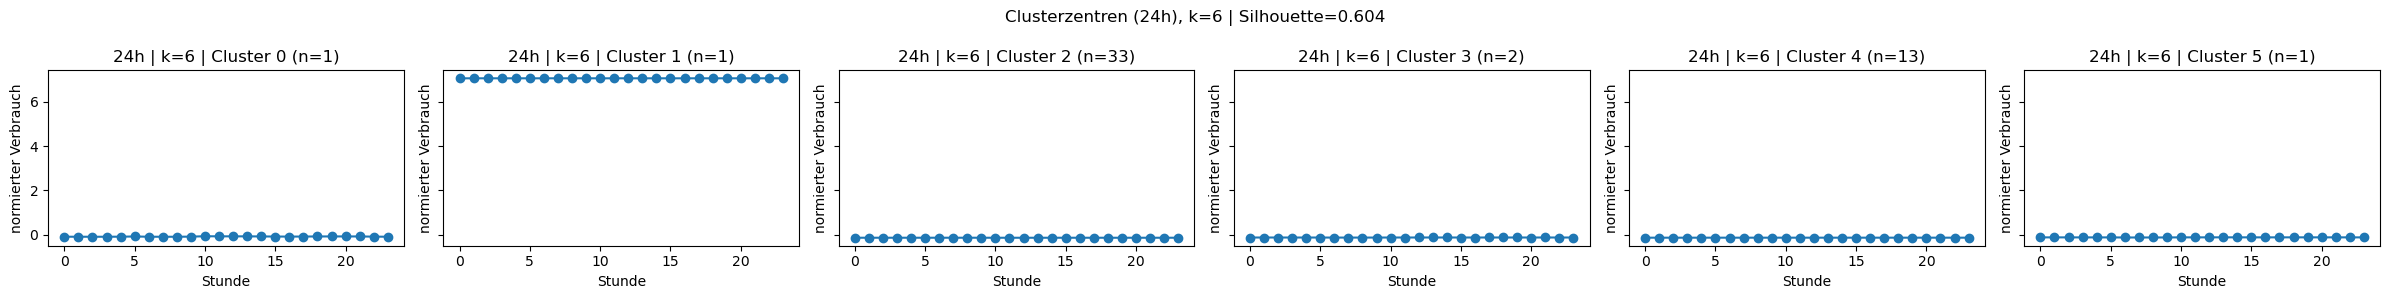

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


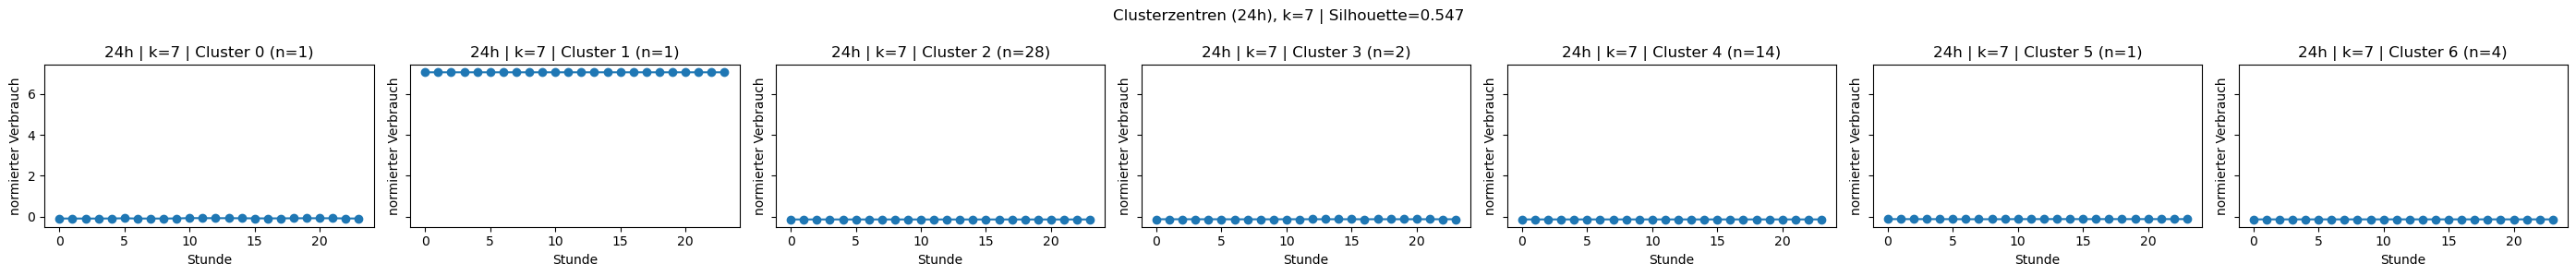

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


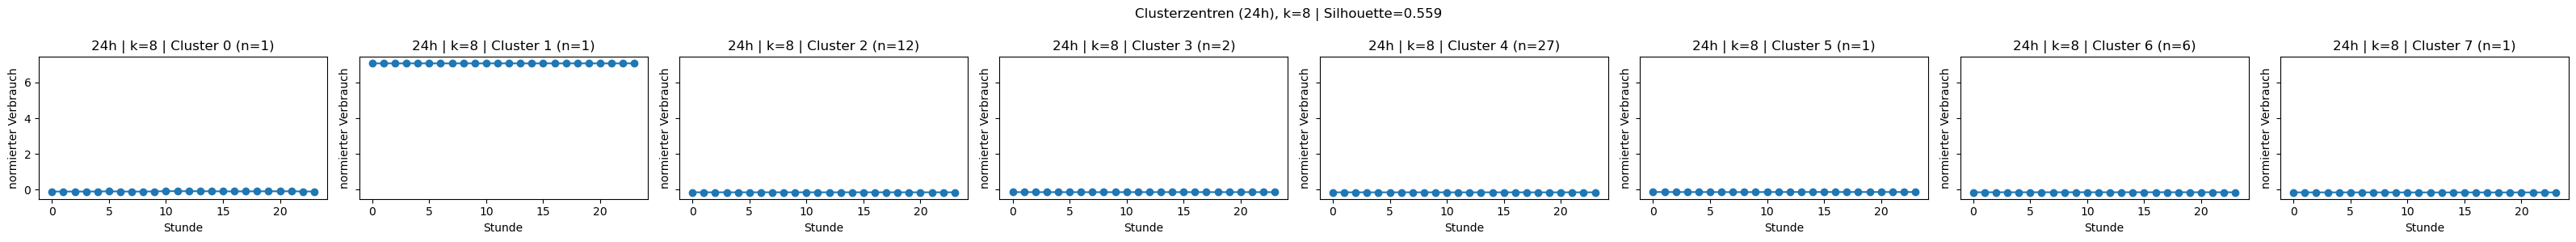

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


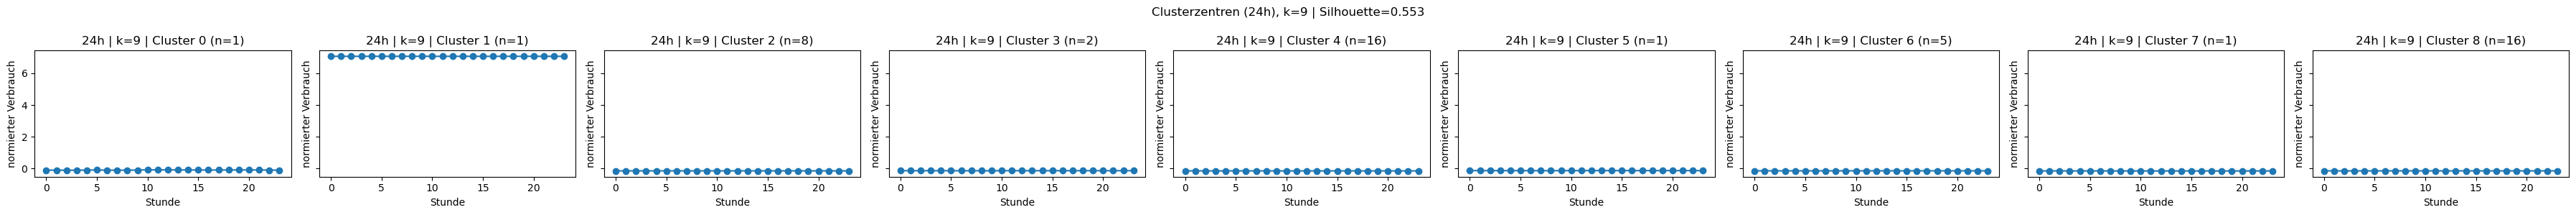

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


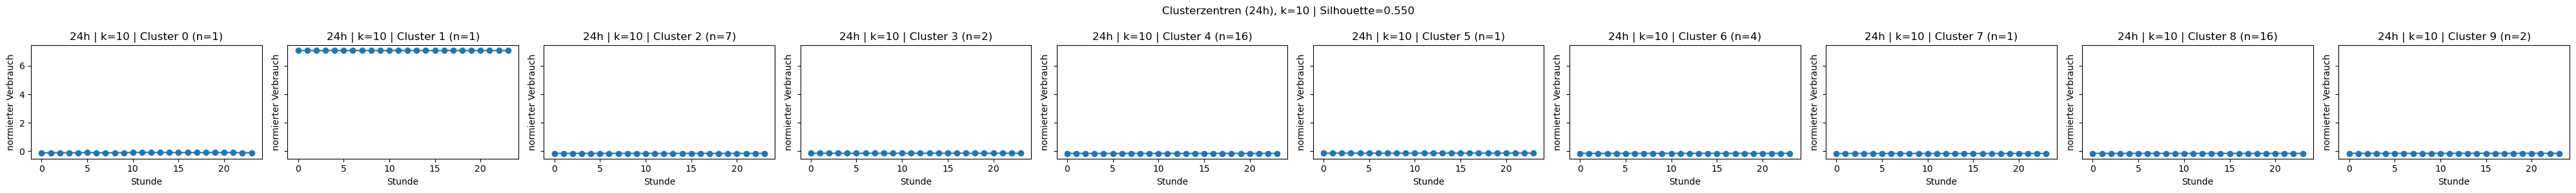

24h Silhouette-Scores: {2: 0.979738273767288, 3: 0.9055309905875388, 4: 0.7953609894226265, 5: 0.6005355745737615, 6: 0.6041176257077168, 7: 0.5468070692344285, 8: 0.5589559844582979, 9: 0.5533231876184687, 10: 0.5497668142972941}
Bestes k (24h): 2 mit Score 0.9797


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


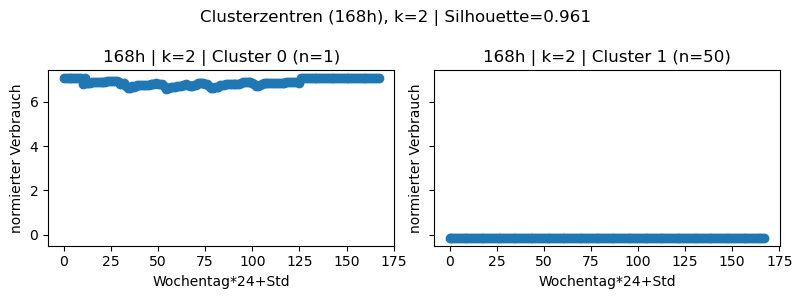

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


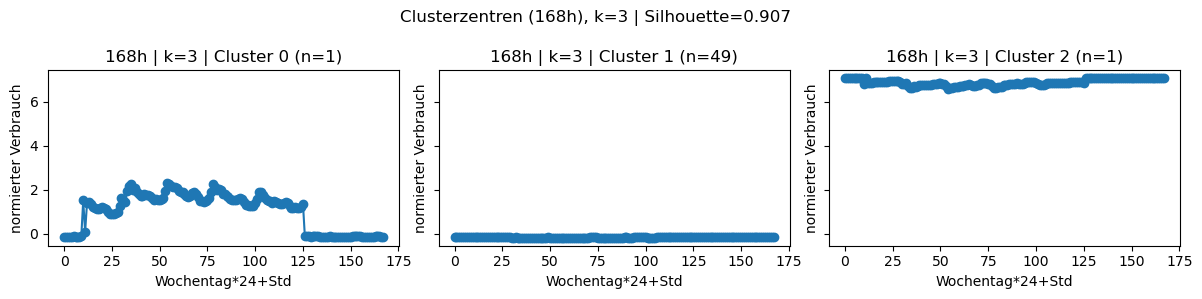

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


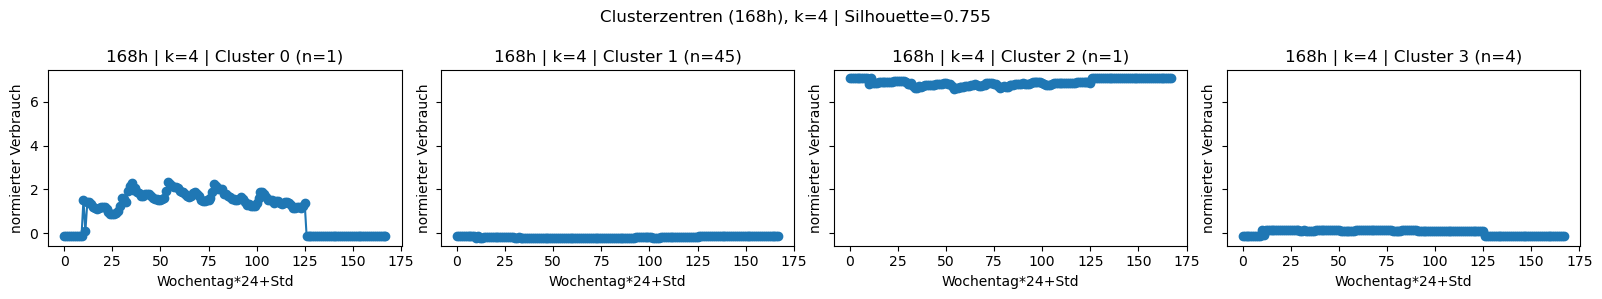

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


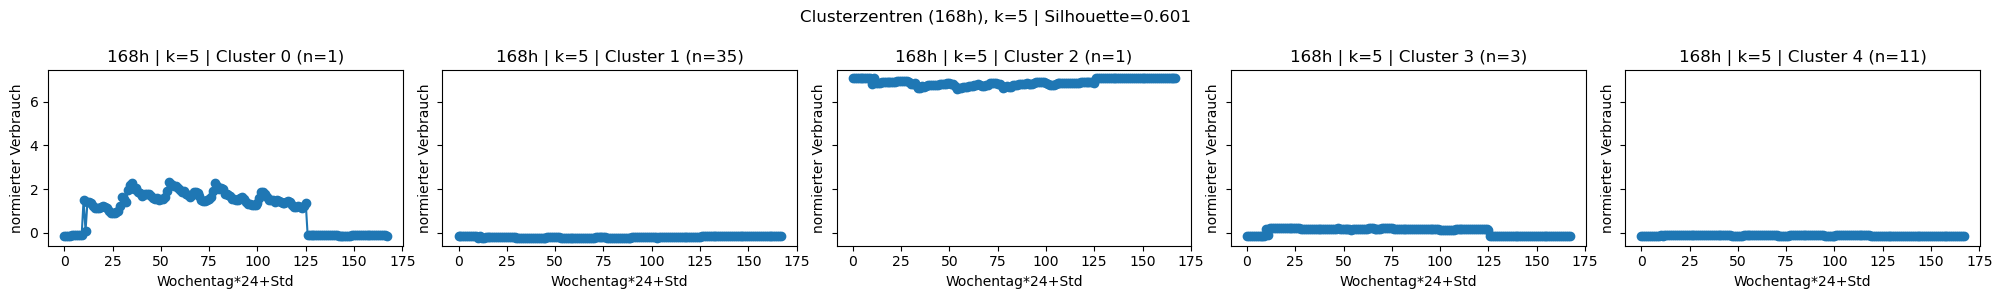

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


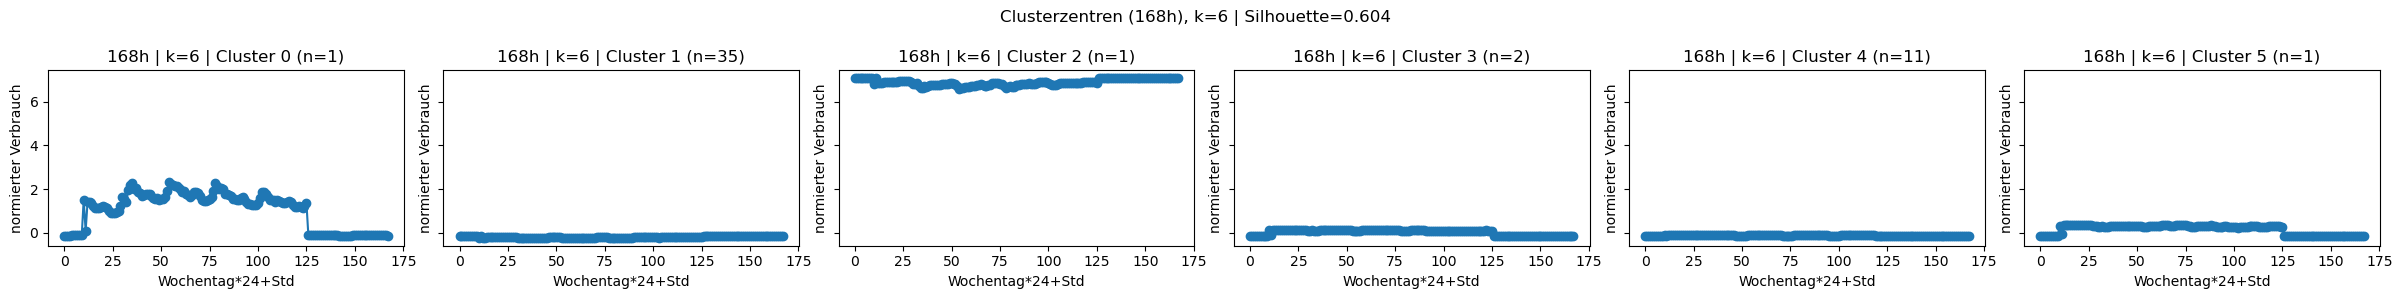

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


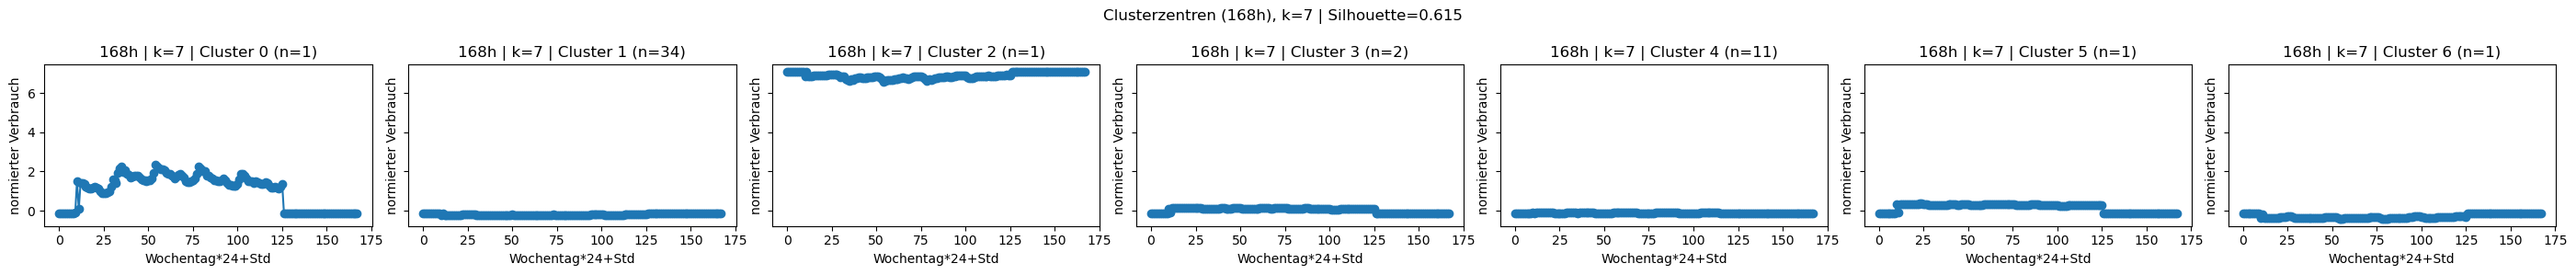

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


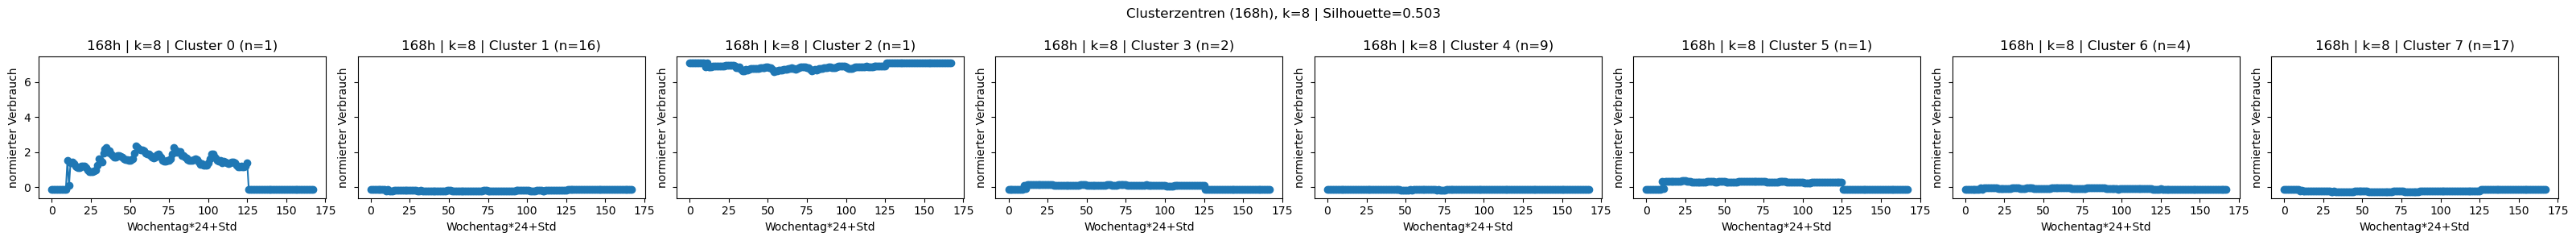

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


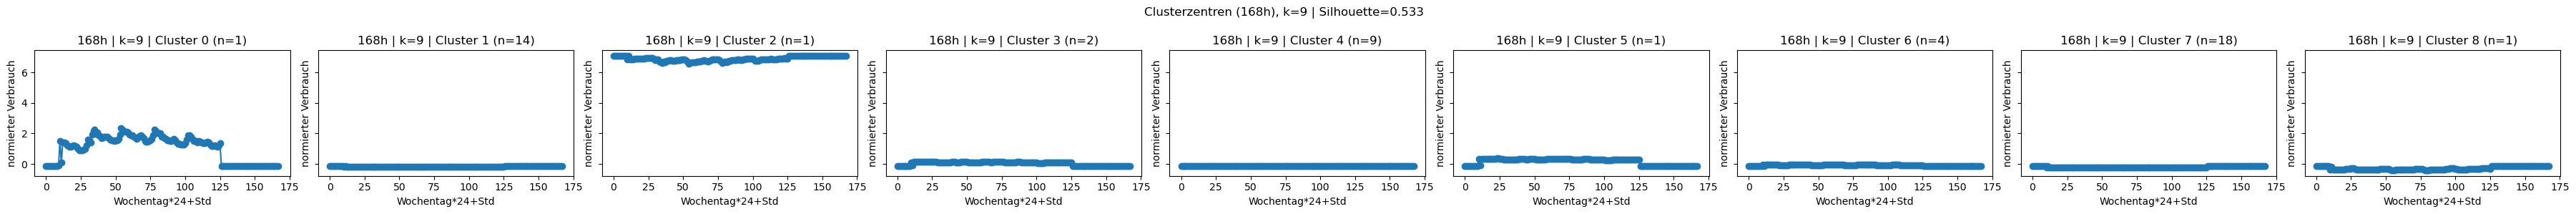

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


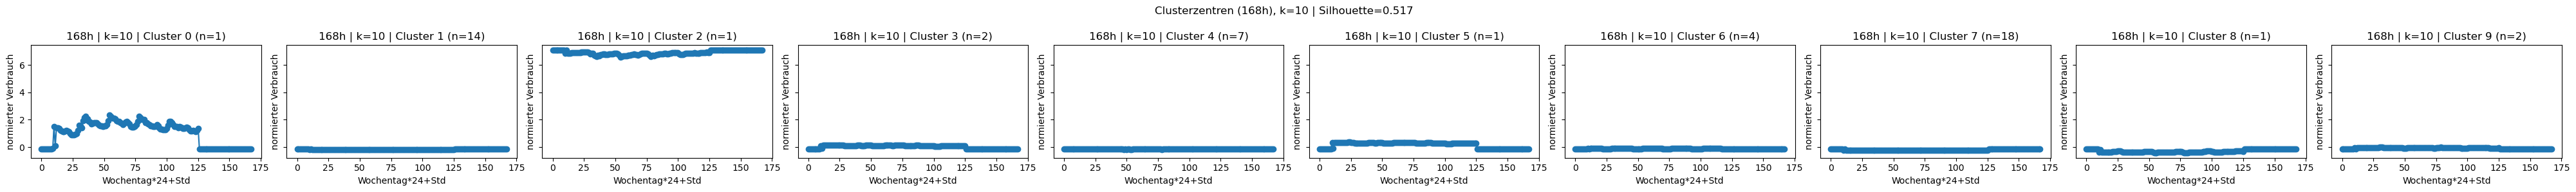

168h Silhouette-Scores: {2: 0.9608673966845277, 3: 0.9065085626969929, 4: 0.7548993252424029, 5: 0.6009864121699332, 6: 0.6037649405269008, 7: 0.6147837930253084, 8: 0.5031617726044301, 9: 0.5328187072312767, 10: 0.5170423772361389}
Bestes k (168h): 2 mit Score 0.9609
Medoids (24h, k=5): {0: 'FL_00352254.PLAN.MengeHH', 1: 'FL_00024360.PLAN.MengeGA', 2: 'FL_00352243.PLAN.MengeHH', 3: 'KN_00001613.PLAN.Menge', 4: 'FL_00352189.PLAN.MengeHH'}


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [8]:
# === Setup & Imports ===
import os
os.environ["OMP_NUM_THREADS"] = "1"  # vermeidet MKL-Warnung/Leak unter Windows

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

# ---------------------------------------------------------------------
# 0) Hilfsfunktionen
# ---------------------------------------------------------------------
def build_profiles_from_series(series_dfs):
    """Baut 24h- und 168h-Profile für jedes Dict-Item."""
    def build_profile(df, mode="24h"):
        if mode == "24h":
            prof = df.groupby("hour")["consumption"].mean()
            return prof.values  # 24
        elif mode == "168h":
            tmp = df.copy()
            tmp["week_hour"] = tmp["weekday"]*24 + tmp["hour"]
            prof = tmp.groupby("week_hour")["consumption"].mean()
            return prof.values  # 168

    profiles_24h, profiles_168h = {}, {}
    for key, df in series_dfs.items():
        df = df.copy()
        df.index = pd.to_datetime(df.index)
        df = df[~df.index.duplicated(keep='first')]
        df = df.sort_index().resample('h').interpolate().asfreq('h')
        # falls 'hour'/'weekday' fehlen sollten:
        if "hour" not in df.columns:    df["hour"] = df.index.hour
        if "weekday" not in df.columns: df["weekday"] = df.index.weekday

        profiles_24h[key]  = build_profile(df, "24h")
        profiles_168h[key] = build_profile(df, "168h")

    keys = list(profiles_24h.keys())
    X_24h  = np.vstack([profiles_24h[k]  for k in keys])
    X_168h = np.vstack([profiles_168h[k] for k in keys])

    # Standardisieren (Skalendifferenzen neutralisieren)
    X_24h  = StandardScaler().fit_transform(X_24h)
    X_168h = StandardScaler().fit_transform(X_168h)
    return keys, X_24h, X_168h

def kmeans_sweep_and_plot(X, mode_name="24h", k_min=2, k_max=10, random_state=42):
    """
    Sweep über k, Silhouette berechnen, Clusterzentren pro k plotten.
    Achtung: plottet viele Grafiken – ggf. k_max reduzieren.
    """
    n_series = X.shape[0]
    k_list = [k for k in range(k_min, k_max+1) if k < n_series]  # KMeans verlangt k < n_samples
    sil = {}

    for k in k_list:
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = km.fit_predict(X)
        sil[k] = silhouette_score(X, labels)

        # --- Clusterzentren als Mittelprofil der normierten Serien ---
        n_clusters = len(np.unique(labels))
        fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 3), sharey=True)
        if n_clusters == 1:
            axes = [axes]

        for c in range(n_clusters):
            ax = axes[c]
            profs = X[labels == c]
            center = profs.mean(axis=0)
            ax.plot(center, marker="o")
            ax.set_title(f"{mode_name} | k={k} | Cluster {c} (n={len(profs)})")
            ax.set_xlabel("Stunde" if mode_name=="24h" else "Wochentag*24+Std")
            ax.set_ylabel("normierter Verbrauch")
        plt.suptitle(f"Clusterzentren ({mode_name}), k={k} | Silhouette={sil[k]:.3f}")
        plt.tight_layout()
        plt.show()

    # Übersicht der Silhouette-Scores
    print(f"{mode_name} Silhouette-Scores:", {k: float(s) for k, s in sil.items()})
    best_k = max(sil, key=sil.get)
    print(f"Bestes k ({mode_name}): {best_k} mit Score {sil[best_k]:.4f}")
    return sil

def compute_medoids(X, labels, keys):
    """Bestimmt Medoids (Serie mit kleinster Gesamtdistanz im Cluster)."""
    medoids = {}
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        D = pairwise_distances(X[idx], metric="euclidean")
        med_local = idx[np.argmin(D.sum(axis=1))]
        medoids[int(c)] = keys[int(med_local)]
    return medoids

# ---------------------------------------------------------------------
# 1) Profile bauen (falls X_24h/X_168h und keys noch nicht existieren)
# ---------------------------------------------------------------------
try:
    keys, X_24h, X_168h  # prüft, ob schon definiert
except NameError:
    keys, X_24h, X_168h = build_profiles_from_series(series_dfs)

# ---------------------------------------------------------------------
# 2) Sweep & Plots für 24h und 168h
# ---------------------------------------------------------------------
sil_24h  = kmeans_sweep_and_plot(X_24h,  mode_name="24h",  k_min=2, k_max=10)
sil_168h = kmeans_sweep_and_plot(X_168h, mode_name="168h", k_min=2, k_max=10)

# ---------------------------------------------------------------------
# 3) Optional: Medoids für das inhaltlich gewählte k bestimmen
#    (Beispiel: nimm das k mit guter Interpretierbarkeit, z.B. k=5)
# ---------------------------------------------------------------------
chosen_k = 5  # <-- hier dein fachlich sinnvolles k setzen
km_24h = KMeans(n_clusters=chosen_k, random_state=42, n_init="auto").fit(X_24h)
labels_24h = km_24h.labels_
medoids_24h = compute_medoids(X_24h, labels_24h, keys)
print(f"Medoids (24h, k={chosen_k}):", medoids_24h)

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette (24h, row-zscore): 0.3550138405423276


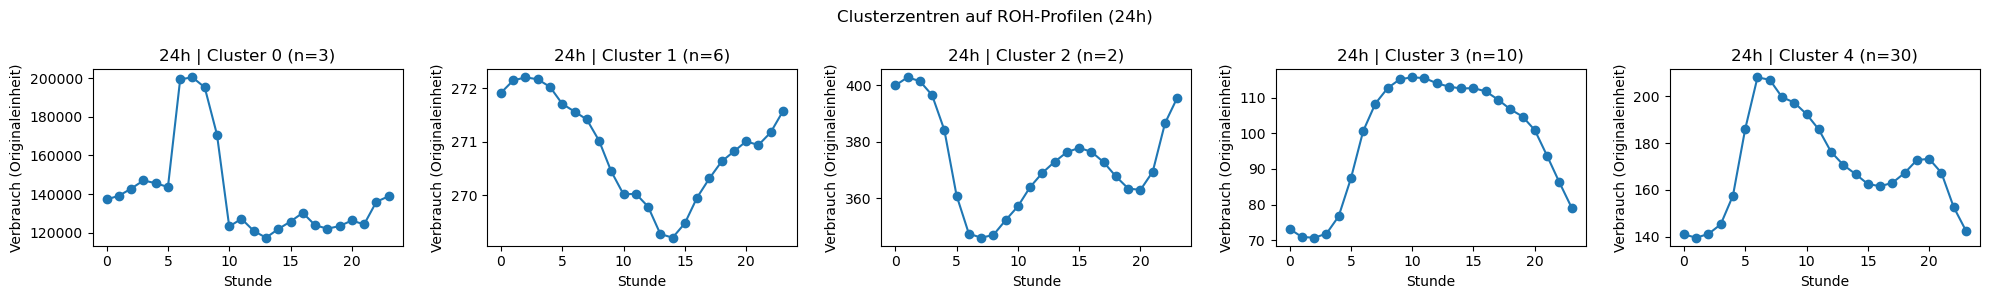

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- 1) Roh-Profile bauen (ohne Spaltenskalierung) ---
# Falls du X_24h_raw / X_168h_raw noch nicht hast:
X_24h_raw  = np.vstack([profiles_24h[k]  for k in keys])   # Form: (n_series, 24)
X_168h_raw = np.vstack([profiles_168h[k] for k in keys])   # Form: (n_series, 168)

# --- 2) Zeilenweise Z-Norm (Form-bezogen) ---
def zscore_rows(X):
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True)
    sd[sd == 0] = 1.0
    return (X - mu) / sd

X_24h = zscore_rows(X_24h_raw)
X_168h = zscore_rows(X_168h_raw)

# --- 3) Clustering (z.B. 24h, k frei wählbar) ---
k = 5  # probier hier 2..10
km = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = km.fit_predict(X_24h)

print("Silhouette (24h, row-zscore):", silhouette_score(X_24h, labels))

# --- 4) Zentren PLOTTEN – aber aus den ROH-Profilen (!), damit Peaks sichtbar sind ---
def plot_cluster_centers_from_raw(X_raw, labels, mode="24h"):
    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 3), sharey=False)
    if n_clusters == 1: axes = [axes]
    for c, ax in enumerate(axes):
        profs_raw = X_raw[labels == c]
        center_raw = profs_raw.mean(axis=0)            # echtes Mittel der Originalprofile
        ax.plot(center_raw, marker="o")
        ax.set_title(f"{mode} | Cluster {c} (n={len(profs_raw)})")
        ax.set_xlabel("Stunde" if mode=="24h" else "Wochentag*24+Std")
        ax.set_ylabel("Verbrauch (Originaleinheit)")
    plt.suptitle(f"Clusterzentren auf ROH-Profilen ({mode})")
    plt.tight_layout()
    plt.show()

plot_cluster_centers_from_raw(X_24h_raw, labels, mode="24h")
# optional:
# plot_cluster_centers_from_raw(X_168h_raw, labels_168h, mode="168h")


In [11]:
def minmax_rows(X):
    mn = X.min(axis=1, keepdims=True)
    mx = X.max(axis=1, keepdims=True)
    return (X - mn) / (mx - mn + 1e-9)
X_24h_mm = minmax_rows(X_24h_raw)

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette (24h, k=5, min-max je Serie): 0.426


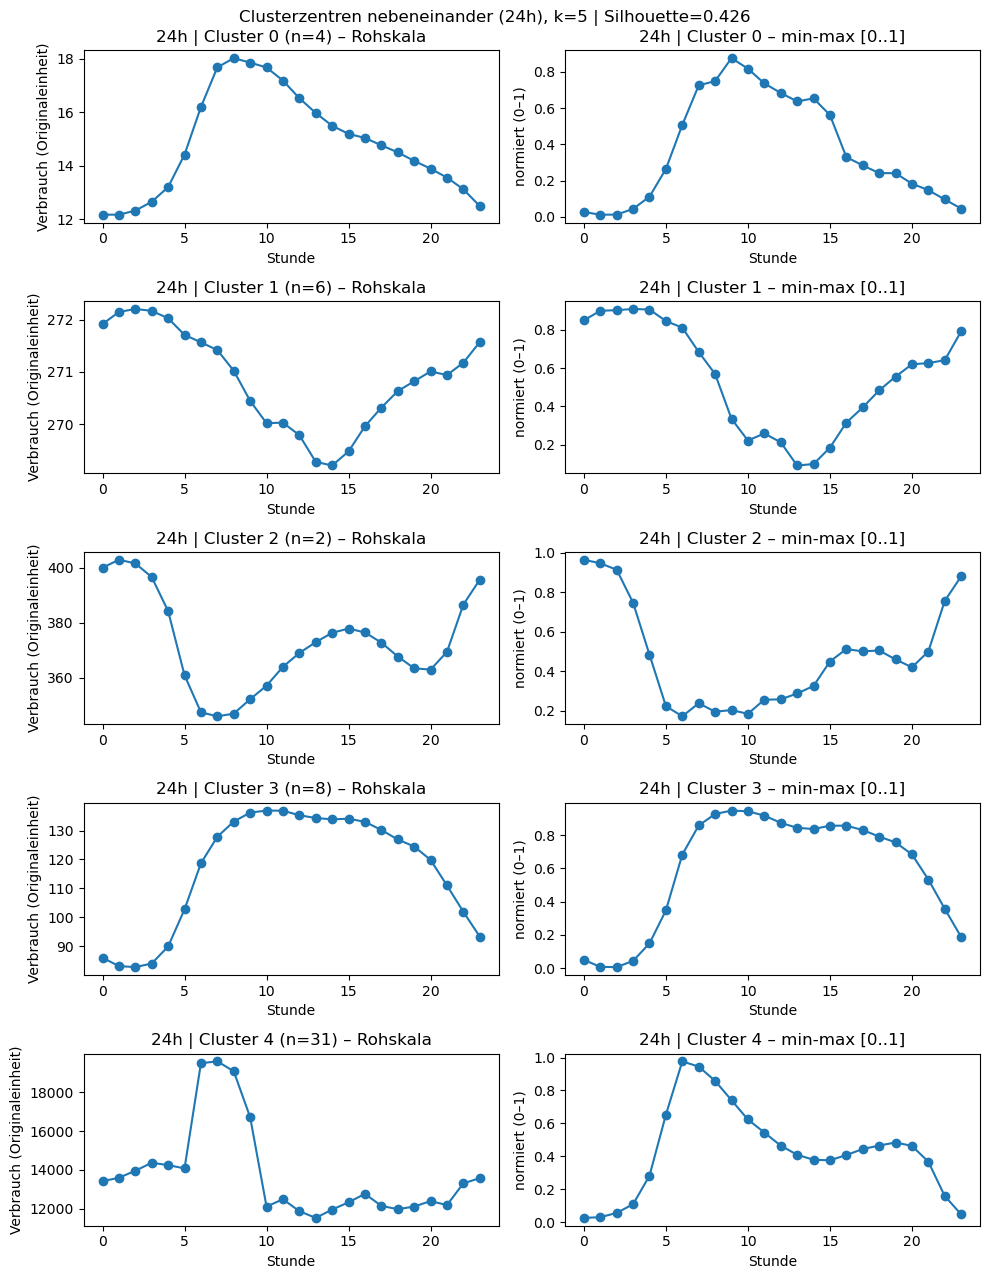

In [12]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def minmax_rows(X):
    mn = X.min(axis=1, keepdims=True)
    mx = X.max(axis=1, keepdims=True)
    return (X - mn) / (mx - mn + 1e-9)

def cluster_and_plot_side_by_side(X_raw, mode="24h", k=5, random_state=42):
    """
    X_raw: np.array, shape (n_series, 24) oder (n_series, 168)
    mode:  "24h" oder "168h" (nur für Achsenbeschriftung)
    k:     Anzahl Cluster
    """
    # 1) Clustern auf min-max-normalisierten Reihen (Form/Pegel-unabhängig)
    X_mm = minmax_rows(X_raw)
    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels = km.fit_predict(X_mm)
    sil = silhouette_score(X_mm, labels)
    print(f"Silhouette ({mode}, k={k}, min-max je Serie): {sil:.3f}")

    n_clusters = len(np.unique(labels))
    # 2) Grid: pro Cluster 2 Plots (links Roh, rechts min-max)
    fig, axes = plt.subplots(
        n_clusters, 2,
        figsize=(10, 2.6*n_clusters),
        sharex=False, sharey=False
    )
    if n_clusters == 1:
        axes = np.array([[axes[0], axes[1]]])  # konsistente 2D-Indexierung

    for c in range(n_clusters):
        idx = (labels == c)
        profs_raw = X_raw[idx]
        profs_mm  = X_mm[idx]
        center_raw = profs_raw.mean(axis=0) if profs_raw.size else np.zeros(X_raw.shape[1])
        center_mm  = profs_mm.mean(axis=0)  if profs_mm.size  else np.zeros(X_raw.shape[1])

        # Links: Rohskala
        axL = axes[c, 0]
        axL.plot(center_raw, marker="o")
        axL.set_title(f"{mode} | Cluster {c} (n={idx.sum()}) – Rohskala")
        axL.set_xlabel("Stunde" if mode=="24h" else "Wochentag*24+Std")
        axL.set_ylabel("Verbrauch (Originaleinheit)")

        # Rechts: 0–1 Skala (Durchschnitt der min-max-Profile)
        axR = axes[c, 1]
        axR.plot(center_mm, marker="o")
        axR.set_title(f"{mode} | Cluster {c} – min-max [0..1]")
        axR.set_xlabel("Stunde" if mode=="24h" else "Wochentag*24+Std")
        axR.set_ylabel("normiert (0–1)")

    plt.suptitle(f"Clusterzentren nebeneinander ({mode}), k={k} | Silhouette={sil:.3f}")
    plt.tight_layout()
    plt.show()

# ===== Anwendung =====
# Für Tagesprofile:
cluster_and_plot_side_by_side(X_24h_raw, mode="24h", k=5)


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette (Winter, k=5): 0.473


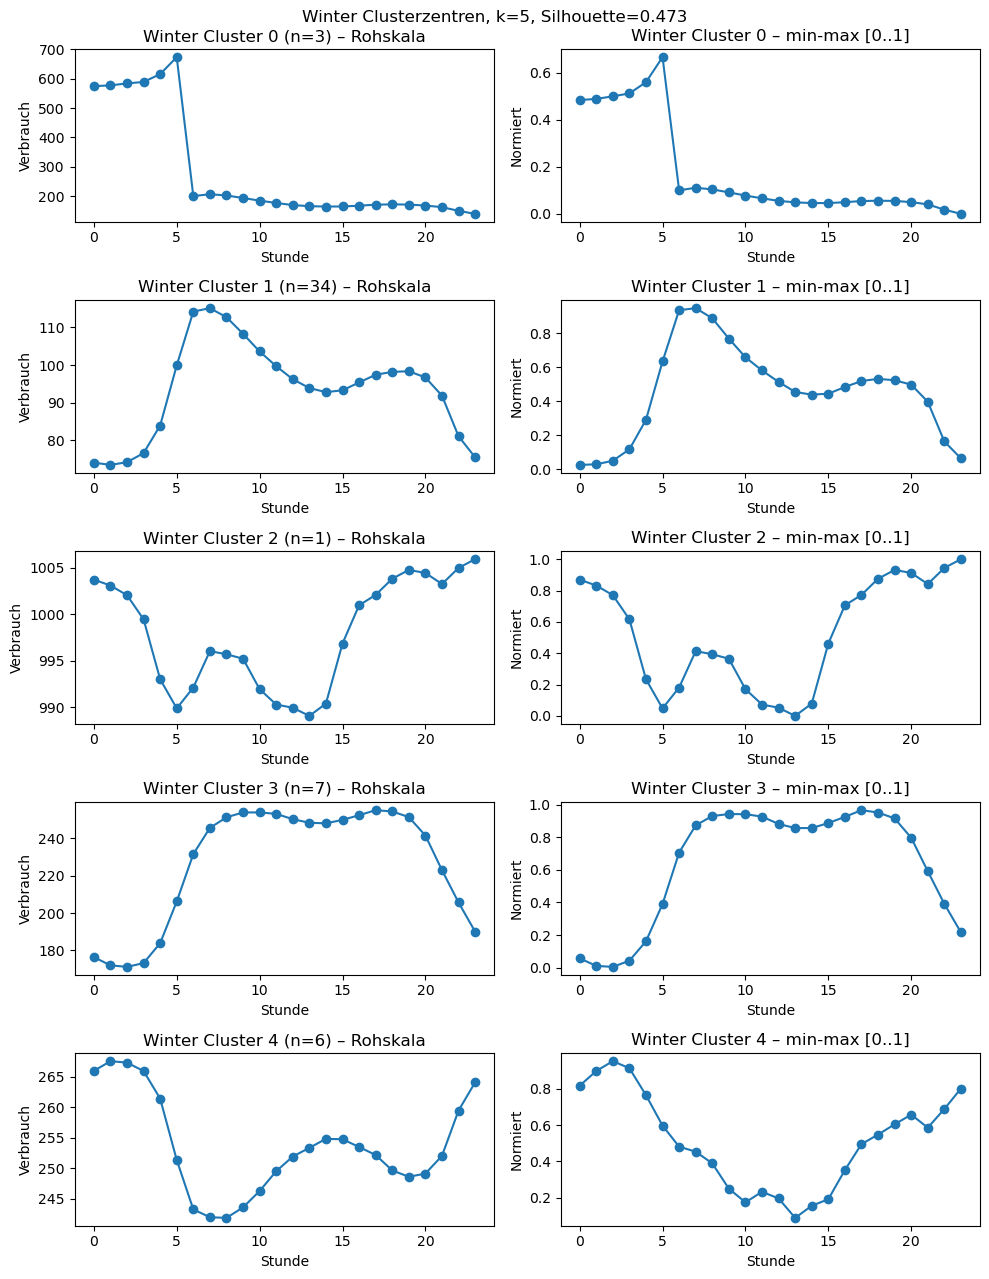

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette (Sommer, k=5): 0.330


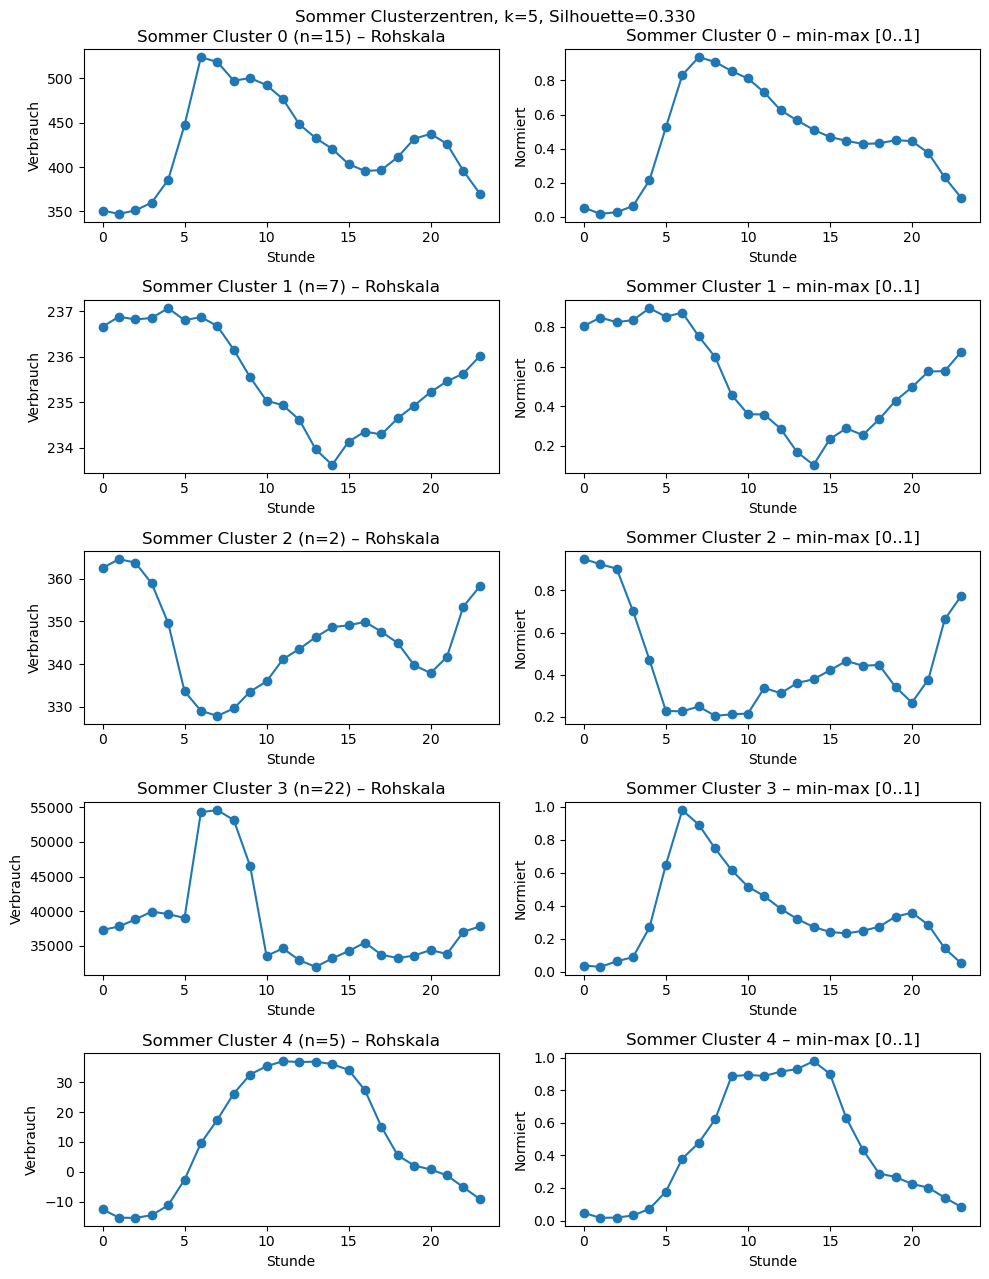

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Helper: min-max norm pro Serie ---
def minmax_rows(X):
    mn = X.min(axis=1, keepdims=True)
    mx = X.max(axis=1, keepdims=True)
    return (X - mn) / (mx - mn + 1e-9)

# --- 1) Profile mit Winter/Sommer Split ---
def build_seasonal_profiles(series_dfs):
    keys = []
    prof24_winter, prof24_summer = [], []

    for key, df in series_dfs.items():
        df = df.copy()
        df.index = pd.to_datetime(df.index)
        df = df[~df.index.duplicated(keep='first')]
        df = df.sort_index().resample('h').interpolate().asfreq('h')

        if "hour" not in df.columns: df["hour"] = df.index.hour
        if "month" not in df.columns: df["month"] = df.index.month

        # Winter = Okt–März, Sommer = Apr–Sep
        df_winter = df[df["month"].isin([10,11,12,1,2,3])]
        df_summer = df[df["month"].isin([4,5,6,7,8,9])]

        if len(df_winter) < 24*30 or len(df_summer) < 24*30:
            continue  # zu wenige Daten

        p24_w = df_winter.groupby("hour")["consumption"].mean()
        p24_s = df_summer.groupby("hour")["consumption"].mean()

        if len(p24_w)==24 and len(p24_s)==24:
            keys.append(key)
            prof24_winter.append(p24_w.values)
            prof24_summer.append(p24_s.values)

    return keys, np.vstack(prof24_winter), np.vstack(prof24_summer)

keys, X_winter_raw, X_summer_raw = build_seasonal_profiles(series_dfs)

# --- 2) Funktion zum Clustern & Plotten ---
def cluster_and_plot(X_raw, mode="Winter", k=5, random_state=42):
    X_mm = minmax_rows(X_raw)
    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels = km.fit_predict(X_mm)
    sil = silhouette_score(X_mm, labels)
    print(f"Silhouette ({mode}, k={k}): {sil:.3f}")

    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(n_clusters, 2, figsize=(10, 2.6*n_clusters))
    if n_clusters==1: axes = np.array([[axes[0], axes[1]]])

    for c in range(n_clusters):
        idx = (labels == c)
        profs_raw = X_raw[idx]
        profs_mm  = X_mm[idx]
        center_raw = profs_raw.mean(axis=0)
        center_mm  = profs_mm.mean(axis=0)

        # Links = echte Skala
        axes[c,0].plot(center_raw, marker="o")
        axes[c,0].set_title(f"{mode} Cluster {c} (n={idx.sum()}) – Rohskala")
        axes[c,0].set_xlabel("Stunde"); axes[c,0].set_ylabel("Verbrauch")

        # Rechts = Form (0-1 skaliert)
        axes[c,1].plot(center_mm, marker="o")
        axes[c,1].set_title(f"{mode} Cluster {c} – min-max [0..1]")
        axes[c,1].set_xlabel("Stunde"); axes[c,1].set_ylabel("Normiert")

    plt.suptitle(f"{mode} Clusterzentren, k={k}, Silhouette={sil:.3f}")
    plt.tight_layout(); plt.show()
    return labels

# --- 3) Anwendung: Winter & Sommer separat ---
labels_w = cluster_and_plot(X_winter_raw, mode="Winter", k=5)
labels_s = cluster_and_plot(X_summer_raw, mode="Sommer", k=5)


In [14]:
from sklearn.metrics import pairwise_distances
import numpy as np

def compute_medoids(X_raw, labels, keys):
    """
    Bestimmt pro Cluster den Medoid (= Serie mit kleinster Gesamtdistanz).
    X_raw : Array (n_series, n_features)
    labels: Clusterlabels (Array der Länge n_series)
    keys  : Liste mit Serien-IDs (gleiche Reihenfolge wie X_raw)
    """
    medoids = {}
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue
        # Distanzmatrix im Cluster
        D = pairwise_distances(X_raw[idx], metric="euclidean")
        # Index der Serie mit kleinster Gesamtdistanz
        med_local = idx[np.argmin(D.sum(axis=1))]
        medoids[int(c)] = keys[int(med_local)]
    return medoids

# ---- Anwendung: Winter ----
medoids_winter = compute_medoids(X_winter_raw, labels_w, keys)
print("Winter-Medoids:", medoids_winter)

# ---- Anwendung: Sommer ----
medoids_sommer = compute_medoids(X_summer_raw, labels_s, keys)
print("Sommer-Medoids:", medoids_sommer)


Winter-Medoids: {0: 'FL_00352254.PLAN.MengeHH', 1: 'CV_00005607.PLAN.Menge', 2: 'FL_00352244.PLAN.MengeGA', 3: 'KN_00001602.PLAN.Menge', 4: 'FL_00025248.PLAN.MengeGA'}
Sommer-Medoids: {0: 'FL_00352243.PLAN.MengeHH', 1: 'FL_00025248.PLAN.MengeGA', 2: 'FL_00352244.PLAN.MengeGA', 3: 'FL_00352191.PLAN.MengeHH', 4: 'KN_00001602.PLAN.Menge'}


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette (Winter, k=5): 0.473


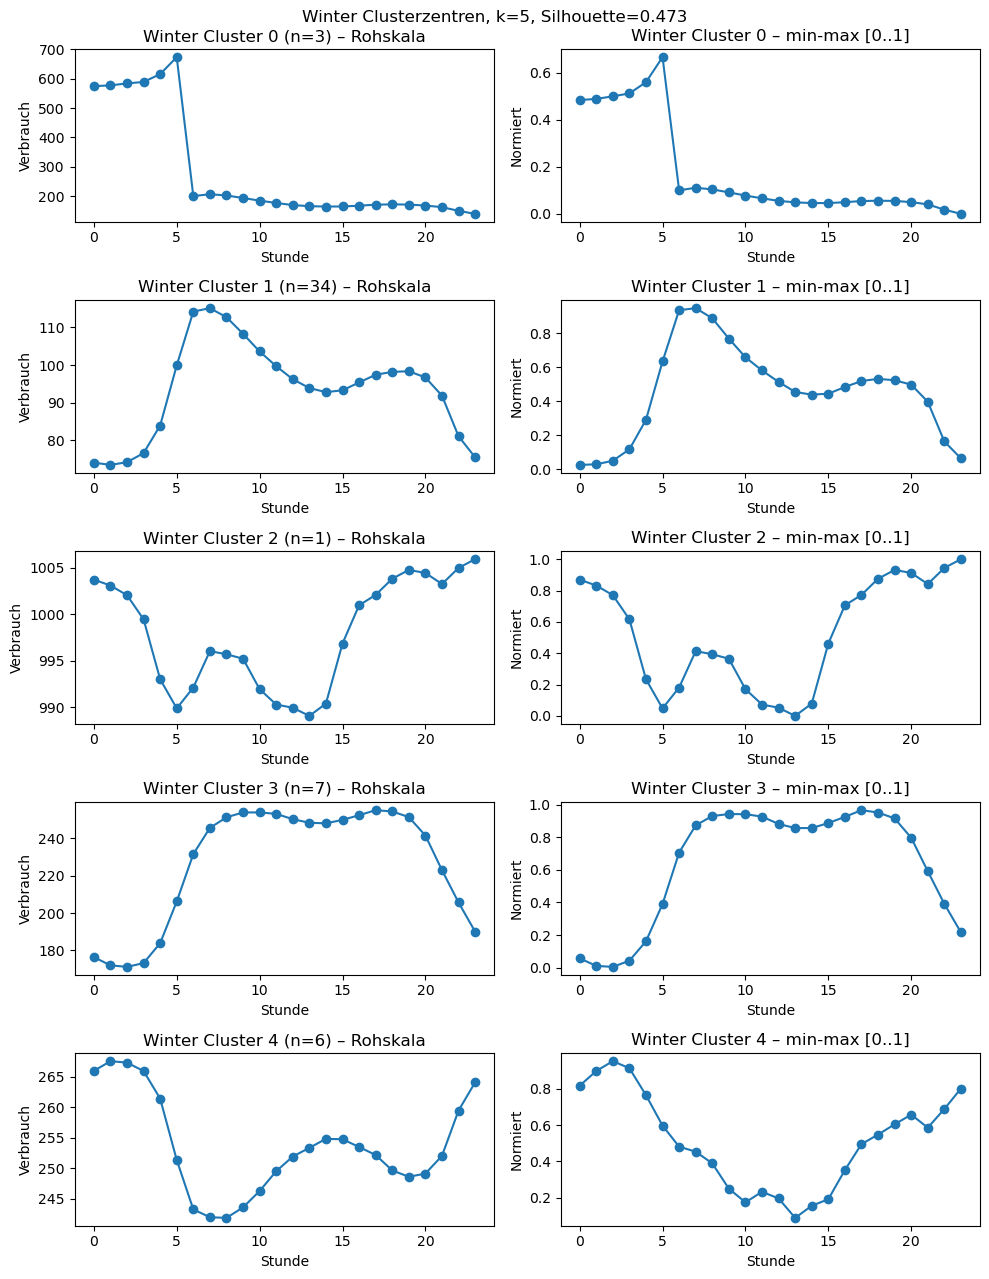

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette (Sommer, k=5): 0.330


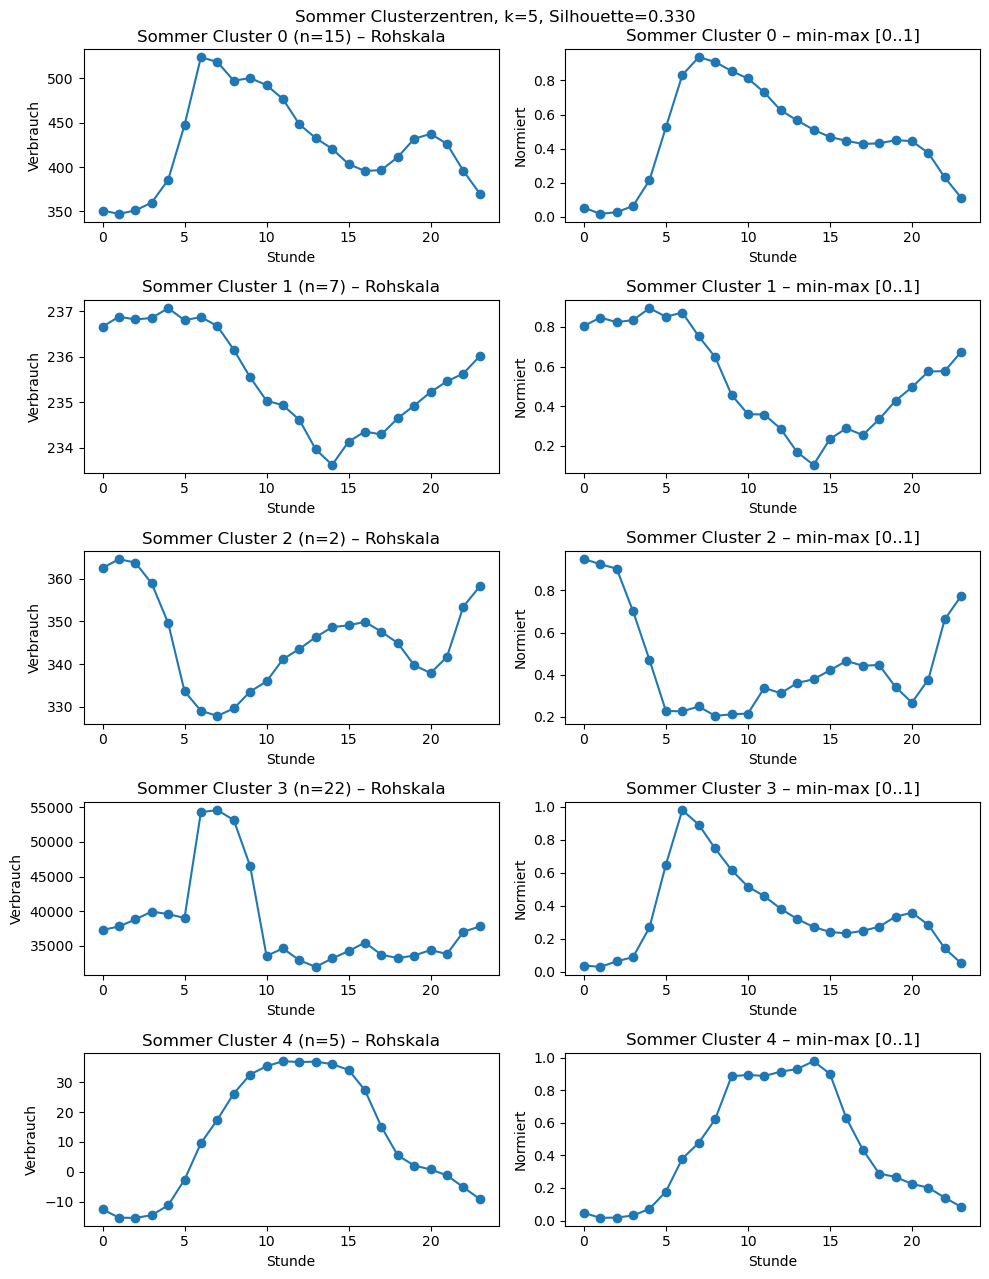

In [22]:
# --- Helper: min-max norm pro Serie ---
def minmax_rows(X):
    mn = X.min(axis=1, keepdims=True)
    mx = X.max(axis=1, keepdims=True)
    return (X - mn) / (mx - mn + 1e-9)

# --- 1) Profile mit Winter/Sommer Split ---
def build_seasonal_profiles(series_dfs):
    keys = []
    prof24_winter, prof24_summer = [], []

    for key, df in series_dfs.items():
        df = df.copy()
        df.index = pd.to_datetime(df.index)
        df = df[~df.index.duplicated(keep='first')]
        df = df.sort_index().resample('h').interpolate().asfreq('h')

        if "hour" not in df.columns: df["hour"] = df.index.hour
        if "month" not in df.columns: df["month"] = df.index.month

        # Winter = Okt–März, Sommer = Apr–Sep
        df_winter = df[df["month"].isin([10,11,12,1,2,3])]
        df_summer = df[df["month"].isin([4,5,6,7,8,9])]

        if len(df_winter) < 24*30 or len(df_summer) < 24*30:
            continue  # zu wenige Daten

        p24_w = df_winter.groupby("hour")["consumption"].mean()
        p24_s = df_summer.groupby("hour")["consumption"].mean()

        if len(p24_w)==24 and len(p24_s)==24:
            keys.append(key)
            prof24_winter.append(p24_w.values)
            prof24_summer.append(p24_s.values)

    return keys, np.vstack(prof24_winter), np.vstack(prof24_summer)

keys, X_winter_raw, X_summer_raw = build_seasonal_profiles(series_dfs)

# --- 2) Funktion zum Clustern & Plotten ---
def cluster_and_plot(X_raw, mode="Winter", k=5, random_state=42):
    X_mm = minmax_rows(X_raw)
    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels = km.fit_predict(X_mm)
    sil = silhouette_score(X_mm, labels)
    print(f"Silhouette ({mode}, k={k}): {sil:.3f}")

    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(n_clusters, 2, figsize=(10, 2.6*n_clusters))
    if n_clusters==1: axes = np.array([[axes[0], axes[1]]])

    for c in range(n_clusters):
        idx = (labels == c)
        profs_raw = X_raw[idx]
        profs_mm  = X_mm[idx]
        center_raw = profs_raw.mean(axis=0)
        center_mm  = profs_mm.mean(axis=0)

        # Links = echte Skala
        axes[c,0].plot(center_raw, marker="o")
        axes[c,0].set_title(f"{mode} Cluster {c} (n={idx.sum()}) – Rohskala")
        axes[c,0].set_xlabel("Stunde"); axes[c,0].set_ylabel("Verbrauch")

        # Rechts = Form (0-1 skaliert)
        axes[c,1].plot(center_mm, marker="o")
        axes[c,1].set_title(f"{mode} Cluster {c} – min-max [0..1]")
        axes[c,1].set_xlabel("Stunde"); axes[c,1].set_ylabel("Normiert")

    plt.suptitle(f"{mode} Clusterzentren, k={k}, Silhouette={sil:.3f}")
    plt.tight_layout(); plt.show()
    return labels

# --- 3) Anwendung: Winter & Sommer separat ---
labels_w = cluster_and_plot(X_winter_raw, mode="Winter", k=5)
labels_s = cluster_and_plot(X_summer_raw, mode="Sommer", k=5)

In [21]:
medoids_winter = compute_medoids(X_winter_raw, labels_w, keys)
print("Winter-Medoids:", medoids_winter)

medoids_sommer = compute_medoids(X_summer_raw, labels_s, keys)
print("Sommer-Medoids:", medoids_sommer)

Winter-Medoids: {0: 'FL_00352254.PLAN.MengeHH', 1: 'CV_00005607.PLAN.Menge', 2: 'FL_00025248.PLAN.MengeGA', 3: 'KN_00001602.PLAN.Menge'}
Sommer-Medoids: {0: 'KN_00001886.PLAN.Menge', 1: 'FL_00025248.PLAN.MengeGA', 2: 'FL_00352244.PLAN.MengeGA', 3: 'FL_00352191.PLAN.MengeHH'}


In [23]:
import os, time
os.environ["OMP_NUM_THREADS"] = "1"   # vermeidet MKL-Warnung unter Windows

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- identisch zu deinem Metric-Setup ---
def calc_metrics(y, y_hat):
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    mae  = mean_absolute_error(y, y_hat)
    return rmse, mae

def prep_df(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.duplicated(keep='first')].sort_index().resample('h').interpolate().asfreq('h')
    # falls hour/weekday/month/is_weekend fehlen:
    if "hour" not in df.columns:      df["hour"]      = df.index.hour
    if "weekday" not in df.columns:   df["weekday"]   = df.index.weekday
    if "month" not in df.columns:     df["month"]     = df.index.month
    if "is_weekend" not in df.columns:df["is_weekend"]= df["weekday"].isin([5,6]).astype(int)
    return df

def split_train_test(df):
    train = df.loc[:'2017-12-31']
    test  = df.loc['2018-01-01':]
    return train, test

# ==================== Deine Modell-Settings ====================
features_full = ['hour','weekday','month','is_weekend','w_tl','w_rf',
                 'w_ff','w_ffx','w_cglo','w_so_h','w_rr','w_rrm',
                 'w_tb10','w_tb20','CEGH_WAP','THE_WAP']

order = (1,0,2)
seasonal_order = (1,0,1,24)
trend = "c"  # intercept
solver = "powell"   # "powell" geht auch, ist aber langsamer

# ==================== 1) Medoid fitten ====================
def fit_medoid(medoid_key, series_dfs, exog_cols=features_full):
    dfm = prep_df(series_dfs[medoid_key])
    train, test = split_train_test(dfm)

    t0 = time.perf_counter()
    mod = SARIMAX(train['consumption'],
                  exog=train[exog_cols],
                  order=order, seasonal_order=seasonal_order, trend=trend,
                  enforce_stationarity=True, enforce_invertibility=True)
    res = mod.fit(disp=False, method=solver, maxiter=300)
    t1 = time.perf_counter()

    # Forecast auf Testbereich
    y_true = test['consumption']
    t_pred0 = time.perf_counter()
    yhat = res.get_forecast(steps=len(test), exog=test[exog_cols]).predicted_mean
    t_pred1 = time.perf_counter()

    rmse, mae = calc_metrics(y_true, yhat)
    info = {
        "key": medoid_key, "role": "medoid",
        "fit_s": t1 - t0, "pred_s": t_pred1 - t_pred0,
        "rmse": rmse, "mae": mae
    }
    return res, info

# ==================== 2) Transfer-Fit (dynamische Teile einfrieren) ====================
def transfer_fit(target_key, res_medoid, series_dfs, exog_cols=features_full, free_sigma2=True):
    dft = prep_df(series_dfs[target_key])
    train, test = split_train_test(dft)

    model_t = SARIMAX(train['consumption'],
                      exog=train[exog_cols],
                      order=order, seasonal_order=seasonal_order, trend=trend,
                      enforce_stationarity=True, enforce_invertibility=True)

    # Welche Parameter sollen FREI bleiben? (Intercept & Exog-Betas; optional sigma2)
    pn = model_t.param_names
    free = set()
    for name in pn:
        if "intercept" in name:
            free.add(name)
    # exog coeffs benutzen exog-Namen
    for name in getattr(model_t, "exog_names", []):
        free.add(name)
    if free_sigma2 and 'sigma2' in pn:
        free.add('sigma2')

    # Alle anderen Parameter auf Medoid-Werte fixieren
    cons = []
    for name, val in zip(pn, res_medoid.params):
        if name not in free:
            cons.append(f"{name} = {val}")
    constraints = ", ".join(cons)

    # Fit (sehr schnell, wenige freie Parameter)
    t0 = time.perf_counter()
    res_t = model_t.fit_constrained(constraints, disp=False)
    t1 = time.perf_counter()

    # Forecast auf Testbereich
    y_true = test['consumption']
    yhat = res_t.get_forecast(steps=len(test), exog=test[exog_cols]).predicted_mean
    rmse, mae = calc_metrics(y_true, yhat)

    info = {
        "key": target_key, "role": "transfer",
        "fit_s": t1 - t0, "pred_s": np.nan,  # optional: extra messen
        "rmse": rmse, "mae": mae
    }
    return res_t, info

# ==================== 3) Pipeline für EINEN Cluster ====================
def run_cluster(cluster_keys, medoid_key, series_dfs, exog_cols=features_full):
    # 1x Medoid fitten
    res_m, info_m = fit_medoid(medoid_key, series_dfs, exog_cols=exog_cols)

    # Transfer auf alle anderen Serien
    infos = [info_m]
    transferred = {}
    for key in cluster_keys:
        if key == medoid_key:
            continue
        try:
            res_t, info_t = transfer_fit(key, res_m, series_dfs, exog_cols=exog_cols)
            transferred[key] = res_t
            infos.append(info_t)
        except Exception as e:
            infos.append({"key": key, "role": "transfer", "error": str(e),
                          "fit_s": np.nan, "pred_s": np.nan, "rmse": np.nan, "mae": np.nan})
    return res_m, transferred, pd.DataFrame(infos)

# ==================== 4) Beispielaufruf ====================
# Angenommen, du hast (z. B. aus Winter-Split):
# - keys:      Reihenfolge deiner Serien
# - labels_w:  Clusterlabels (gleich lang wie keys)
# - medoids_winter: dict {cluster_id: medoid_key}

# => baue die Mitgliederliste pro Cluster:
def members_from_labels(keys, labels):
    clusters = {}
    for k, lbl in zip(keys, labels):
        clusters.setdefault(int(lbl), []).append(k)
    return clusters

# Beispiel: Winter-Cluster laufen
clusters_w = members_from_labels(keys, labels_w)
results_all = []
models_medoid = {}
models_transfer = {}

for cid, members in clusters_w.items():
    medoid_key = medoids_winter[cid]
    res_m, transferred, df_cluster = run_cluster(members, medoid_key, series_dfs, exog_cols=features_full)
    models_medoid[cid] = res_m
    models_transfer.update(transferred)
    df_cluster["cluster_id"] = cid
    results_all.append(df_cluster)

results_df = pd.concat(results_all, ignore_index=True)
display(results_df.sort_values(["cluster_id","role","rmse"]))

KeyError: 4